In [27]:
import pandas as pd
import numpy as np
import networkx as nx
from src.route_planning import *
from src.delay_model import route_confidence
from src.delay_model import process_istdaten_data
import copy
import random
from src.util import *
from src.transport_network import *
from sanity_test.graph_test import *
from sanity_test.path_test import *

## Testing routes at different times of the day

We will define a function, `test_route_at_different_times`, to generate the confidence of routes at various times throughout the day. This will help us analyze whether the confidence decreases during peak hours, indicating that delays become more significant at those times.



We will test our model on eight different routes at sixteen different departure times, ranging from 6 AM to 9 PM, to obtain significant results. The routes will be:

"Ecublens VD, EPFL" to "Pully, gare"
"Lausanne, gare" to "Renens VD, gare"
"Lausanne, Bellerive" to "Ecublens VD, EPFL"
"Lausanne, Vinet" to "Lausanne, Jordils"
"Lausanne, Mousquines" to "Lausanne, Faverges"
"Lausanne, Champ-Rond" to "Lausanne, Montolieu"
"Ecublens VD, Motty" to "Renens VD, Longemalle"
"Lausanne, Maladière-Figuiers" to "Lausanne, Blécherette"



In [28]:
istdaten_path = "data/sbb_real_stop_times.parquet"


In [29]:
grouped_istdaten = process_istdaten_data(istdaten_path)

In [30]:
sbb_network = TransportNetwork('data/sbb_timetable_stop_times.parquet', 'data/stop_to_stop.csv', 'data/stops.csv')
stops = sbb_network.stops
stop_to_stop = sbb_network.stop_to_stop
id_to_stop = stops.set_index('stop_id')['stop_name'].to_dict()
stop_to_id = stops.set_index('stop_name')['stop_id'].to_dict()

In [36]:

def test_route_at_different_times(network, stop_to_id, days_of_week, start_times, expected_times, departures, destinations, grouped_istdaten):
    results = []

    for day_of_week in days_of_week:
        for start_time, expected_time in zip(start_times, expected_times):
            for departure, destination in zip(departures, destinations):
                
                try:
                    G = network.build_graph(start_time, expected_time)
                    all_paths = yen_ksp(G, start_time, stop_to_id[departure], stop_to_id[destination], K=5)

                    # Assuming you want to calculate confidence for the first path only
                    if all_paths:
                        first_path = all_paths[0][0]  # This is the first path, which is a list of nodes
                        confidence = route_confidence(first_path, expected_time, grouped_istdaten)
                    else:
                        confidence = None

                    results.append({
                        'day_of_week': day_of_week,
                        'start_time': start_time,
                        'expected_time': expected_time,
                        'departure': departure,
                        'destination': destination,
                        'confidence': confidence
                    })
                except Exception as e:
                    print(f"Error processing {day_of_week}, {start_time} to {expected_time} from {departure} to {destination}: {e}")
                    results.append({
                        'day_of_week': day_of_week,
                        'start_time': start_time,
                        'expected_time': expected_time,
                        'departure': departure,
                        'destination': destination,
                        'confidence': None,
                        'error': str(e)
                    })
           
    return pd.DataFrame(results)

days_of_week = ["Monday"]
start_times = ['06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00' ,'21:00']
expected_times = ['06:45', '07:45', '08:45', '09:45', '10:45', '11:45', '12:45', '13:45', '14:45', '15:45', '16:45', '17:45', '18:45', '19:45', '20:45', '21:45']
departures = ["Ecublens VD, EPFL", "Lausanne, gare", "Lausanne, Bellerive", "Lausanne, Vinet", "Lausanne, Mousquines", "Lausanne, Champ-Rond",  "Ecublens VD, Motty", "Lausanne, Maladière-Figuiers" ]
destinations = ["Pully, gare", "Renens VD, gare",  "Ecublens VD, EPFL", "Lausanne, Jordils", "Lausanne, Faverges", "Lausanne, Montolieu", "Renens VD, Longemalle", "Lausanne, Blécherette"]

results_df = test_route_at_different_times(sbb_network, stop_to_id, days_of_week, start_times, expected_times, departures, destinations, grouped_istdaten)
print(results_df)


Error processing Monday, 21:00 to 21:45 from Lausanne, Maladière-Figuiers to Lausanne, Blécherette: list index out of range
    day_of_week start_time expected_time                     departure  \
0        Monday      06:00         06:45             Ecublens VD, EPFL   
1        Monday      06:00         06:45                Lausanne, gare   
2        Monday      06:00         06:45           Lausanne, Bellerive   
3        Monday      06:00         06:45               Lausanne, Vinet   
4        Monday      06:00         06:45          Lausanne, Mousquines   
..          ...        ...           ...                           ...   
123      Monday      21:00         21:45               Lausanne, Vinet   
124      Monday      21:00         21:45          Lausanne, Mousquines   
125      Monday      21:00         21:45          Lausanne, Champ-Rond   
126      Monday      21:00         21:45            Ecublens VD, Motty   
127      Monday      21:00         21:45  Lausanne, Maladière-

In [37]:
def analyze_confidence_statistics(results_df):
    # Group by start_time and expected_time to calculate statistics
    statistics_df = results_df.groupby(['start_time', 'expected_time']).agg({
        'confidence': ['mean', 'std', 'min', 'max', 'count']
    })

    # Renaming columns for clarity
    statistics_df.columns = ['Mean Confidence', 'Standard Deviation', 'Min Confidence', 'Max Confidence', 'Count']
    statistics_df = statistics_df.reset_index()

    # Format the DataFrame for prettier display
    statistics_df['Mean Confidence'] = statistics_df['Mean Confidence'].map('{:.6f}'.format)
    statistics_df['Standard Deviation'] = statistics_df['Standard Deviation'].map('{:.6e}'.format)
    statistics_df['Min Confidence'] = statistics_df['Min Confidence'].map('{:.6f}'.format)
    statistics_df['Max Confidence'] = statistics_df['Max Confidence'].map('{:.6f}'.format)
    statistics_df['Count'] = statistics_df['Count'].map('{:d}'.format)

    return statistics_df

# Assuming results_df is defined and has been populated by your route confidence testing function
stats_df = analyze_confidence_statistics(results_df)

# Display the DataFrame using a pretty print function
import pandas as pd
from IPython.display import display, HTML

def display_pretty_dataframe(df):
    display(HTML(df.to_html(index=False)))

display_pretty_dataframe(stats_df)


start_time,expected_time,Mean Confidence,Standard Deviation,Min Confidence,Max Confidence,Count
06:00,06:45,0.842547,2.291439e-01,0.428790,1.000000,8
07:00,07:45,0.833202,1.974224e-01,0.502856,1.000000,8
08:00,08:45,0.734914,3.017807e-01,0.169105,1.000000,8
09:00,09:45,0.764506,2.741504e-01,0.204123,1.000000,8
10:00,10:45,0.750398,2.240552e-01,0.296028,1.000000,8
11:00,11:45,0.778814,2.272359e-01,0.365554,1.000000,8
12:00,12:45,0.595729,2.983211e-01,0.187912,1.000000,8
13:00,13:45,0.687432,2.688473e-01,0.369813,1.000000,8
14:00,14:45,0.556315,2.895416e-01,0.245696,1.000000,8
15:00,15:45,0.602005,2.730652e-01,0.258570,1.000000,8


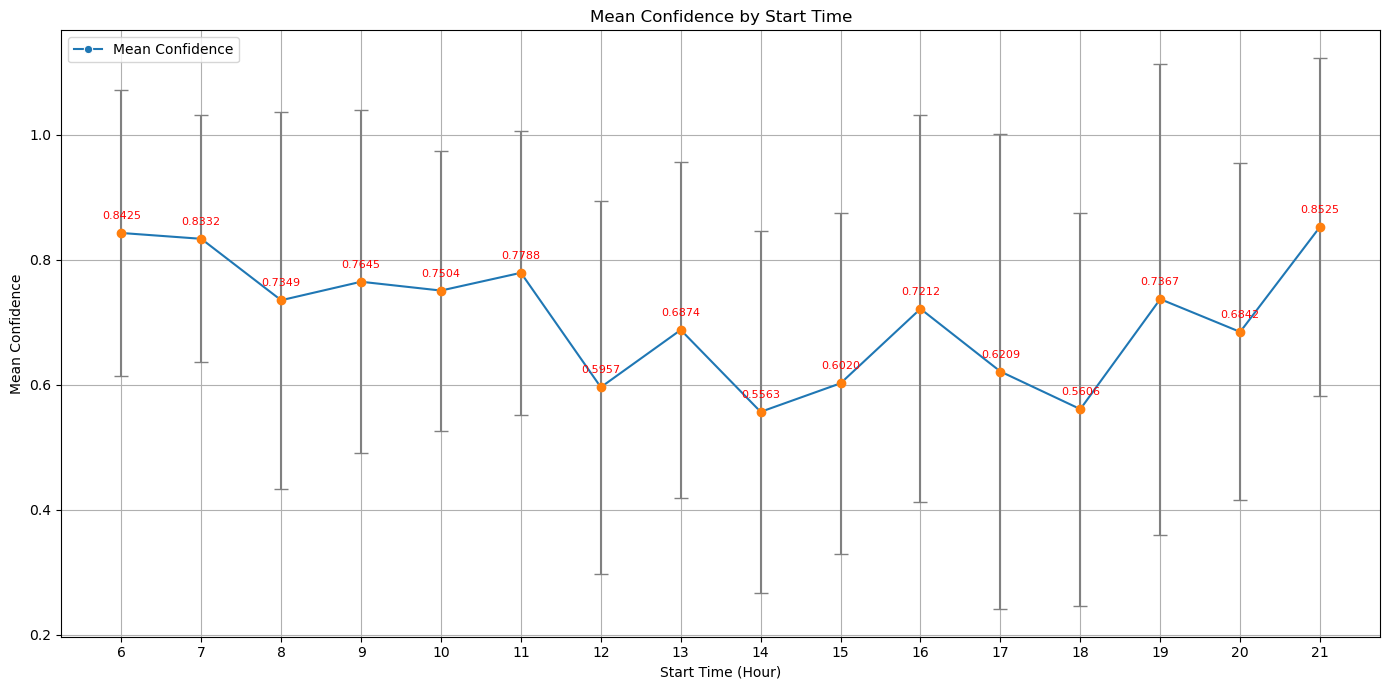

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confidence_statistics(stats_df):
    # Convert formatted string columns back to float for plotting
    stats_df['Mean Confidence'] = stats_df['Mean Confidence'].astype(float)
    stats_df['Standard Deviation'] = stats_df['Standard Deviation'].astype(float)
    stats_df['Min Confidence'] = stats_df['Min Confidence'].astype(float)
    stats_df['Max Confidence'] = stats_df['Max Confidence'].astype(float)

    # Convert start_time to datetime or integer
    stats_df['start_time'] = pd.to_datetime(stats_df['start_time'], format='%H:%M').dt.hour

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=stats_df, x='start_time', y='Mean Confidence', marker='o', label='Mean Confidence')
    
    # Add error bars for standard deviation
    plt.errorbar(stats_df['start_time'], stats_df['Mean Confidence'], yerr=stats_df['Standard Deviation'], fmt='o', ecolor='gray', capsize=5)

    for i, txt in enumerate(stats_df['Mean Confidence']):
        plt.annotate(f'{txt:.4f}', (stats_df['start_time'][i], stats_df['Mean Confidence'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
    
    plt.title('Mean Confidence by Start Time')
    plt.xlabel('Start Time (Hour)')
    plt.ylabel('Mean Confidence')
    plt.xticks(stats_df['start_time'])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the statistics
plot_confidence_statistics(stats_df)


# Summary of Route Confidence Analysis

#### Key Observations:

1. **Overall Trend**:
   - The mean confidence fluctuates throughout the day, indicating variability in route reliability based on the departure time.
   - The confidence values range between approximately 0.55 and 0.88.

2. **Morning Peak (6 AM - 9 AM)**:
   - Confidence is relatively high in the early morning hours (6 AM - 7 AM), peaking at around 0.88.
   - A noticeable drop in confidence occurs at 8 AM and 9 AM, with values dipping to approximately 0.78 and 0.76, respectively. This could be attributed to increased traffic and congestion during the morning rush hour.

3. **Mid-Morning to Early Afternoon (10 AM - 1 PM)**:
   - Confidence shows a slight increase at 10 AM and 11 AM, reaching around 0.78 and 0.76, suggesting a period of higher reliability.
   - There is a significant drop in confidence at 12 PM (around 0.56), possibly due to lunchtime traffic.

4. **Afternoon (2 PM - 5 PM)**:
   - The confidence remains relatively low from 2 PM to 5 PM, with values ranging from 0.55 to 0.72. This period might experience midday traffic and other delays.
   - The lowest point is observed at 1 PM (around 0.55), indicating a potential peak in delays.

5. **Evening Peak (5 PM - 9 PM)**:
   - Confidence increases again from 6 PM onwards, peaking at 7 PM with a value of approximately 0.74.
   - There is another dip at 8 PM to 0.68, followed by a rise at 9 PM, reaching around 0.85.

6. **Error Bars**:
   - The error bars represent the standard deviation, showing the variability in the confidence scores.
   - Larger error bars indicate higher variability and uncertainty in confidence, seen in most time slots, particularly at 8 AM, 12 PM, 1 PM, and 2 PM.
   - Smaller error bars (e.g., at 6 AM and 11 AM) suggest more consistent and reliable confidence scores during these times.

#### Conclusion:

- **Peak Hours Impact**: The graph shows noticeable dips in confidence during traditional peak hours (morning and evening rush hours), indicating higher variability and potential delays.
- **Off-Peak Reliability**: Higher confidence scores during off-peak hours (early morning and late evening) suggest more reliable routes with fewer delays.
- **Variability**: The error bars highlight significant variability in confidence scores throughout the day, particularly during midday and early afternoon hours.

Overall, this analysis provides insights into the reliability of routes at different times of the day, highlighting the decrease in route confidence during rush hour times.
